# This notebook simulates the model-free partitioning of deaths into intrinsic and extrinsic components

# Imports

In [2]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import functools  # Import functools to create a partial function
from scipy import interpolate
from lifelines import NelsonAalenFitter


# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc
from src.model_free_twins import ModelFreeTwins 


# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
denmark_both = HMD(country = 'dan' , gender = 'both', data_type='cohort')
sweden_both = HMD(country = 'swe' , gender = 'both', data_type='cohort')

# Danish Cohort - Herskind

/Users/benshenhar/Library/CloudStorage/GoogleDrive-benshenhar@gmail.com/My Drive/Weizmann/Alon Lab/my papers/extrinsic mortality/code/src/model_free_twins.py:168: RuntimeWarning: invalid value encountered in divide
  hazard = np.where(S > 0, P / S, last_valid)


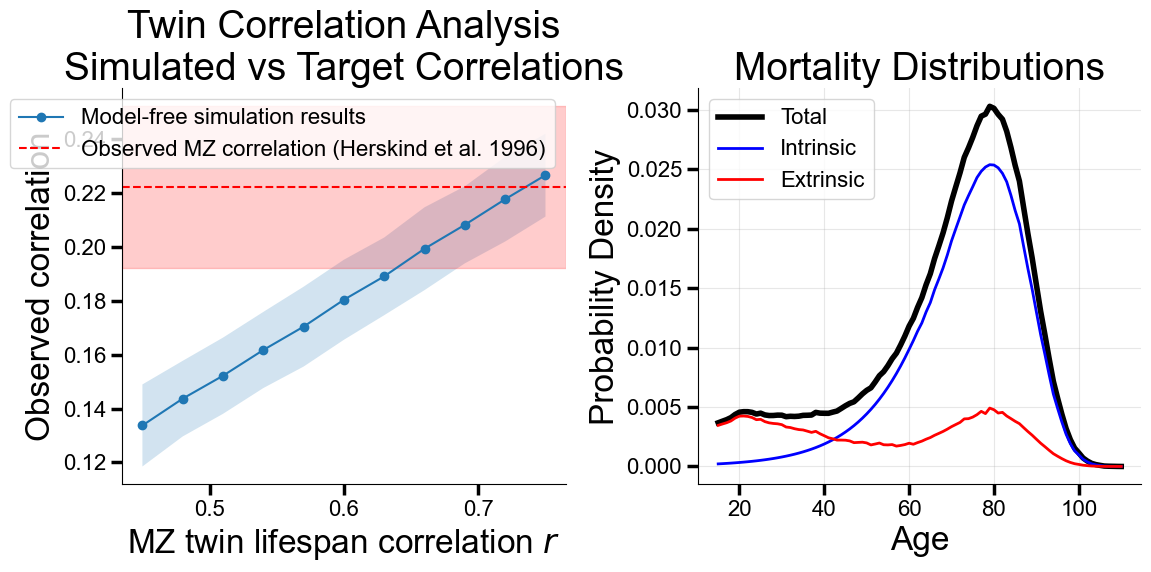

In [4]:
danish_years = np.arange(1870,1900)
danish_mft = ModelFreeTwins(hmd_sim=denmark_both, years=danish_years, intrinsic_to_total_ratio=0.85)
# Create arrays to store results
r_values = np.arange(0.45, 0.76, 0.03)
means = []
stds = []
cis = []

# Run simulations for each r value
for r in r_values:
    mean_corr, std_corr, ci_95 = danish_mft.simulate_correlation_distribution(
        r=r, n_twins=5000, n_runs=500, plot=False
    )
    means.append(mean_corr)
    stds.append(std_corr)
    cis.append(ci_95)

# Convert to arrays for easier plotting
means = np.array(means)
stds = np.array(stds)
cis = np.array(cis)


# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
# Left subplot - correlation analysis
ax1.plot(r_values, means, 'o-', 
         label='Model-free simulation results')
ax1.fill_between(r_values, means - stds, means + stds, alpha=0.2)

# Add herskind combined all MZ data from twin_studies dictionary
herskind_data = td.twin_studies['herskind']['combined']['all_MZ']
herskind_r = herskind_data['r']
herskind_std_lower = herskind_data['std_1'][0]
herskind_std_upper = herskind_data['std_1'][1]

ax1.axhspan(herskind_std_lower, herskind_std_upper, color='red', alpha=0.2)
ax1.axhline(y=herskind_r, color='red', linestyle='--', 
            label='Observed MZ correlation (Herskind et al. 1996)')

ax1.set_xlabel('MZ twin lifespan correlation $r$')
ax1.set_ylabel('Observed correlation')
ax1.set_title('Twin Correlation Analysis\nSimulated vs Target Correlations')
ax1.legend()

# Right subplot - mortality distributions
ax2.plot(danish_mft.ages, danish_mft.total_distribution, 
         label='Total', color='black', linewidth=4)
ax2.plot(danish_mft.ages, danish_mft.intrinsic_distribution,
         label='Intrinsic', color='blue', linewidth=2)
ax2.plot(danish_mft.ages, danish_mft.extrinsic_distribution,
         label='Extrinsic', color='red', linewidth=2)
ax2.set_xlabel('Age')
ax2.set_ylabel('Probability Density')
ax2.set_title('Mortality Distributions')
ax2.grid(False)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()

/var/folders/r5/2q8zzrr15ld3_jcs6mjrvk900000gn/T/ipykernel_91095/4060079618.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


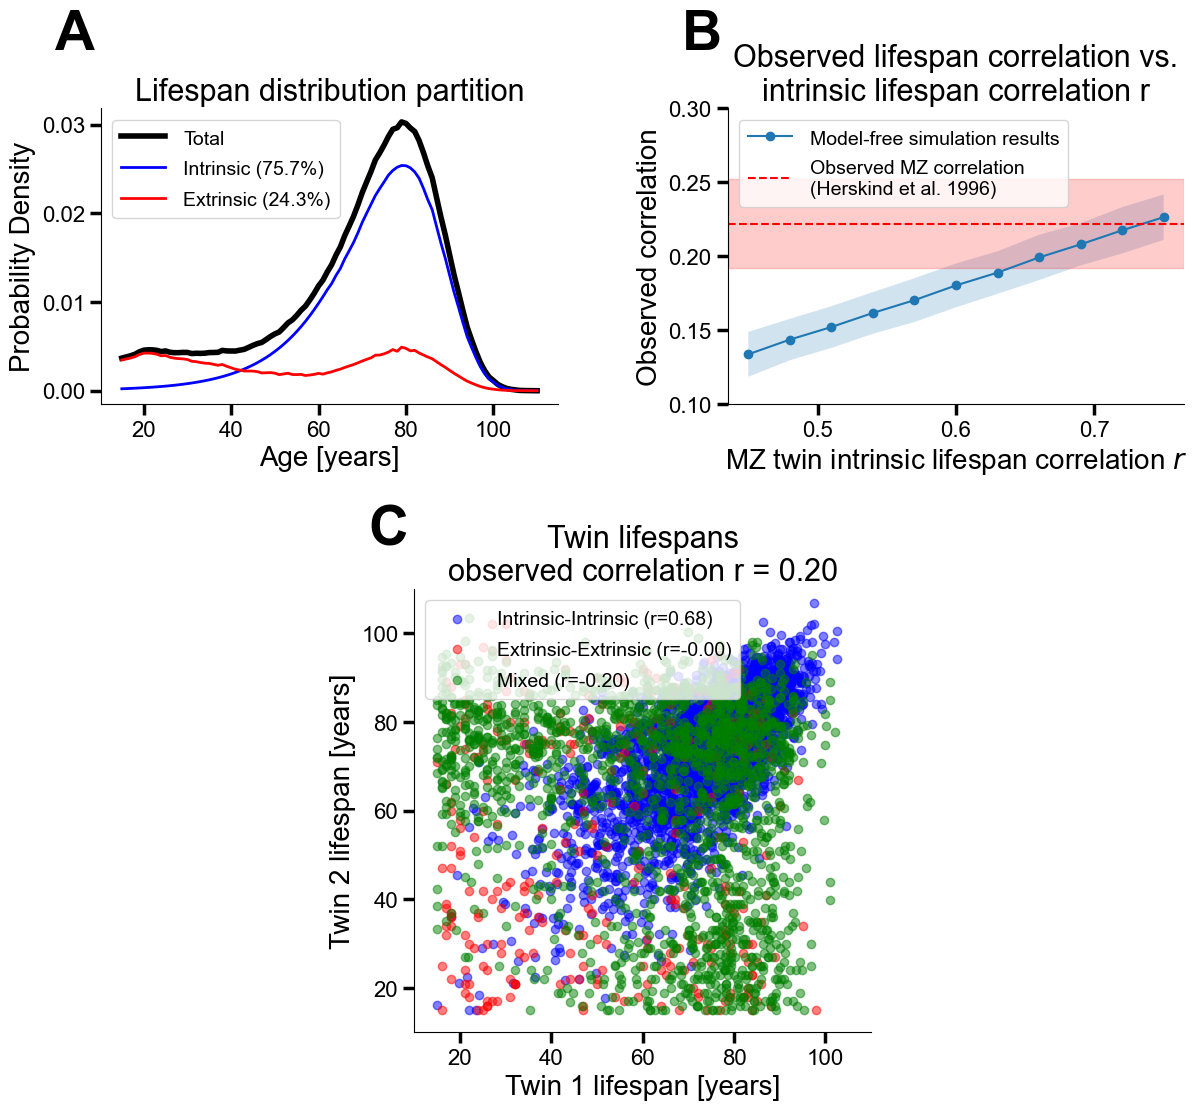

In [5]:
# Create figure with three subplots - 2 on top row, 1 centered on bottom row
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 16, height_ratios=[1, 1.5], hspace=0.5)
# Top row subplots with proportions 7:7 and more spacing
ax2 = fig.add_subplot(gs[0, 0:6])   # Now ax2 is on the left
ax1 = fig.add_subplot(gs[0, 8:14])  # Now ax1 is on the right

# Bottom row subplot centered with proportion 7:7
ax3 = fig.add_subplot(gs[1, 4:10])  # Centered subplot takes 8/16 of width

# Left subplot - mortality distributions (now ax2)
ax2.plot(danish_mft.ages, danish_mft.total_distribution, 
         label='Total', color='black', linewidth=4)
ax2.plot(danish_mft.ages, danish_mft.intrinsic_distribution,
         label=f'Intrinsic ({danish_mft.intrinsic_death_prop:.1%})', color='blue', linewidth=2)
ax2.plot(danish_mft.ages, danish_mft.extrinsic_distribution,
         label=f'Extrinsic ({danish_mft.extrinsic_death_prop:.1%})', color='red', linewidth=2)
ax2.set_xlabel('Age [years]', fontfamily='Arial')
ax2.set_ylabel('Probability Density', fontfamily='Arial')
ax2.set_title('Lifespan distribution partition', fontfamily='Arial')
ax2.grid(False)
ax2.legend(prop={'family': 'Arial'}, loc='upper left')

# Right subplot - correlation analysis (now ax1)
ax1.plot(r_values, means, 'o-', 
         label='Model-free simulation results')
ax1.fill_between(r_values, means - stds, means + stds, alpha=0.2)

# Add herskind combined all MZ data from twin_studies dictionary
herskind_data = td.twin_studies['herskind']['combined']['all_MZ']
herskind_r = herskind_data['r']
herskind_std_lower = herskind_data['std_1'][0]
herskind_std_upper = herskind_data['std_1'][1]

ax1.axhspan(herskind_std_lower, herskind_std_upper, color='red', alpha=0.2)
ax1.axhline(y=herskind_r, color='red', linestyle='--', 
            label='Observed MZ correlation\n(Herskind et al. 1996)')

ax1.set_xlabel('MZ twin intrinsic lifespan correlation $r$', fontfamily='Arial')
ax1.set_ylabel('Observed correlation', fontfamily='Arial')
ax1.set_ylim(0.1, 0.3)
ax1.set_title('Observed lifespan correlation vs.\nintrinsic lifespan correlation r', fontfamily='Arial')
ax1.legend(prop={'family': 'Arial'}, loc='upper left')

# Bottom subplot - twin correlations scatter plot
danish_mft.plot_twin_correlations(n = 5000, r = 0.7, ax=ax3)
ax3.set_xlabel('Twin 1 lifespan [years]', fontfamily='Arial')
ax3.set_ylabel('Twin 2 lifespan [years]', fontfamily='Arial')
ax3.set_title(ax3.get_title(), fontfamily='Arial')
ax3.set_xlim(10, 110)
ax3.set_ylim(10, 110)
ax3.legend(prop={'family': 'Arial'}, loc='upper left')

# Add subplot labels (A), (B), (C)
ax2.text(-0.1, 1.2, 'A', transform=ax2.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax1.text(-0.1, 1.2, 'B', transform=ax1.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')

plt.tight_layout()

# Make all axis labels and titles bigger
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(ax.get_xlabel(), fontfamily='Arial', fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontfamily='Arial', fontsize=20)
    ax.set_title(ax.get_title(), fontfamily='Arial', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    # Update legend font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontfamily('Arial')
            text.set_fontsize(14)